In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn import tree

✅ Jeu d'entraînement : (256349, 12)
✅ Jeu de test : (109865, 12)

🎯 Accuracy du modèle : 0.9320

🧾 Rapport de classification :
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     18239
           2       0.96      0.96      0.96     33065
           3       0.92      0.92      0.92     29598
           4       0.87      0.88      0.87     17256
           5       0.87      0.86      0.87      8526
           6       0.92      0.91      0.92      2855
           7       0.94      0.88      0.91       326

    accuracy                           0.93    109865
   macro avg       0.92      0.91      0.92    109865
weighted avg       0.93      0.93      0.93    109865



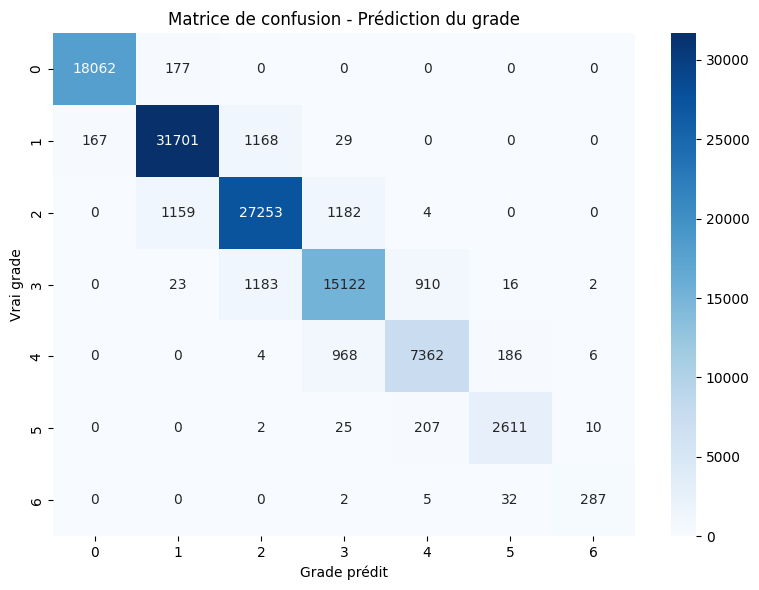

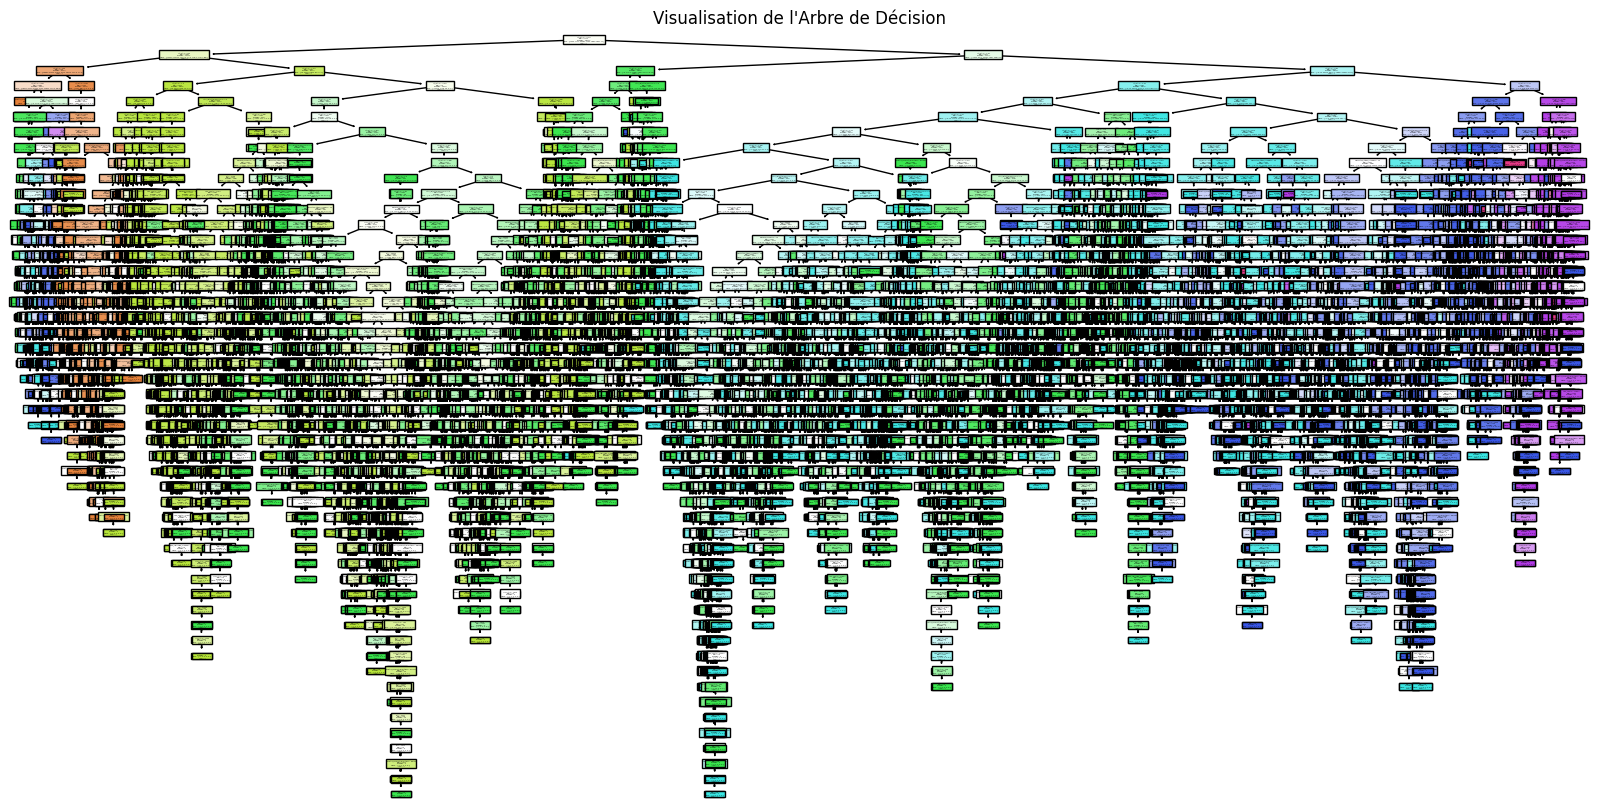

In [2]:
# 🔹 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# 🔹 Encodage rapide (si pas déjà fait)
grade_order = sorted(df['grade'].dropna().unique())
grade_mapping = {grade: idx + 1 for idx, grade in enumerate(grade_order)}
df['grade_encoded'] = df['grade'].map(grade_mapping)

# Encodage supplémentaire
df['home_ownership_encoded'] = df['home_ownership'].astype('category').cat.codes
df['verification_status_encoded'] = df['verification_status'].astype('category').cat.codes
df['loan_status_encoded'] = (df['loan_status'] == 'Charged Off').astype(int)
df['purpose_encoded'] = df['purpose'].astype('category').cat.codes
df['initial_list_status_encoded'] = df['initial_list_status'].map({'w': 1, 'f': 0})
df['application_type_encoded'] = df['application_type'].astype('category').cat.codes

# 🔹 Sélection des variables explicatives
features = [
    'int_rate', 'term', 'revol_util', 'loan_amnt', 'dti', 
    'installment', 'monthly_payment_calculated', 
    'home_ownership_encoded', 'verification_status_encoded',
    'purpose_encoded', 'initial_list_status_encoded',
    'application_type_encoded'
]

X = df[features]
y = df['grade_encoded']

# 🔹 Découpage Train / Test (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"✅ Jeu d'entraînement : {X_train.shape}")
print(f"✅ Jeu de test : {X_test.shape}")

# 🔹 Modèle Arbre de Décision
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 🔹 Prédictions
y_pred = model.predict(X_test)

# 🔹 Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy du modèle : {accuracy:.4f}")

print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 🔹 Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Prédiction du grade")
plt.xlabel("Grade prédit")
plt.ylabel("Vrai grade")
plt.tight_layout()
plt.show()

# 🔹 Optionnel : Visualiser l'arbre
plt.figure(figsize=(20,10))
tree.plot_tree(model, feature_names=features, class_names=[str(i) for i in sorted(y.unique())], filled=True)
plt.title("Visualisation de l'Arbre de Décision")
plt.show()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_22836\2680338944.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


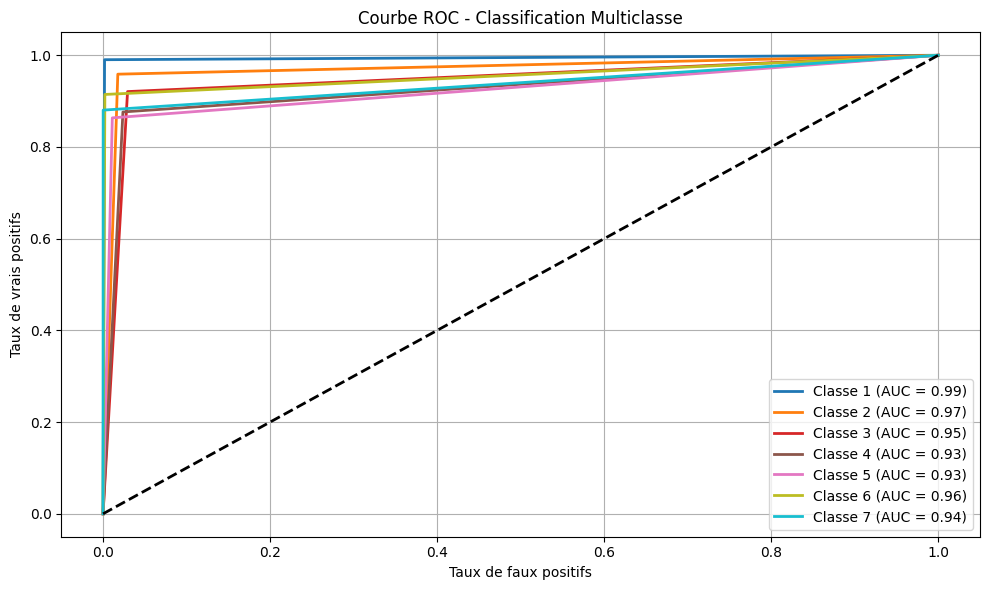

In [3]:
# 🔹 Binarisation des labels (7 classes -> 1 à 7)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# 🔹 Prédiction des probabilités
y_score = model.predict_proba(X_test)

# 🔹 Calcul des courbes ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 🔹 Affichage de la courbe ROC
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f'Classe {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Courbe ROC - Classification Multiclasse")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# 🔹 Définir la grille de paramètres à tester
param_grid = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 🔹 Initialiser le modèle de base
dt = DecisionTreeClassifier(random_state=42)

# 🔹 Setup GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# 🔹 Lancer la recherche
grid_search.fit(X_train, y_train)

# 🔹 Résultats
print(f"✅ Meilleurs paramètres : {grid_search.best_params_}")
print(f"🎯 Meilleure précision : {grid_search.best_score_:.4f}")

# 🔹 Réentraîner le meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 🔹 Évaluer le modèle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("🔍 Rapport de classification :\n", classification_report(y_test, y_pred))
print(f"🎯 Accuracy : {accuracy_score(y_test, y_pred):.4f}")


Fitting 3 folds for each of 160 candidates, totalling 480 fits


KeyboardInterrupt: 

In [ ]:
# 🔹 Créer le dossier s'il n'existe pas
model_dir = "../../models"
os.makedirs(model_dir, exist_ok=True)

# 🔹 Sauvegarde du modèle entraîné
model_path = os.path.join(model_dir, "decision_tree_model.joblib")
joblib.dump(best_model, model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

✅ Modèle enregistré à : ../../models\decision_tree_model.joblib


In [10]:
# Encodage du grade
grade_encoder = LabelEncoder()
df['grade_encoded'] = grade_encoder.fit_transform(df['grade'])

# ✅ Enregistrement du LabelEncoder
joblib.dump(grade_encoder, "../../models/label_encoder_grade.pkl")
print("🎉 LabelEncoder sauvegardé avec succès dans models/label_encoder_grade.pkl")

🎉 LabelEncoder sauvegardé avec succès dans models/label_encoder_grade.pkl


In [5]:
# 📂 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# ✅ Variables fournies par l'utilisateur
features = [
    'purpose',              # Objet du prêt
    'loan_amnt',            # Montant souhaité
    'monthly_income',       # Salaire mensuel
    'emp_length',           # Durée d'emploi
    'home_ownership',        # Type de propriété
    'job_category'
]
target = 'grade'            # Cible : Grade à prédire

# 🧹 Nettoyage : suppression des lignes incomplètes
df = df[features + [target]].dropna()

# 🔢 Encodage des variables catégorielles
le_home = LabelEncoder()
le_purpose = LabelEncoder()
le_grade = LabelEncoder()

df['home_ownership_encoded'] = le_home.fit_transform(df['home_ownership'])
df['purpose_encoded'] = le_purpose.fit_transform(df['purpose'])
df['grade_encoded'] = le_grade.fit_transform(df['grade'])

# 🧮 Jeu de données final
X = df[['loan_amnt', 'monthly_income', 'emp_length', 'home_ownership_encoded', 'purpose_encoded']]
y = df['grade_encoded']

# 🧪 Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🌳 Entraînement du modèle
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)

# 📊 Évaluation
y_pred = model.predict(X_test)
print("🎯 Accuracy du modèle :", round(accuracy_score(y_test, y_pred), 4))
print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 💾 Sauvegarde
#joblib.dump(model, "../../models/decision_tree_model_grade_v2.joblib")
#joblib.dump(le_home, "../../models/label_encoder_home_ownership.pkl")
#joblib.dump(le_purpose, "../../models/label_encoder_purpose.pkl")
#joblib.dump(le_grade, "../../models/label_encoder_grade_v2.pkl")

#print("✅ Modèle et encodeurs enregistrés avec succès.")


🎯 Accuracy du modèle : 0.3249

🧾 Rapport de classification :
              precision    recall  f1-score   support

           0       0.34      0.14      0.20     17443
           1       0.36      0.62      0.45     31806
           2       0.29      0.34      0.32     28145
           3       0.25      0.11      0.15     16622
           4       0.24      0.07      0.11      8261
           5       0.12      0.01      0.02      2699
           6       0.10      0.00      0.01       323

    accuracy                           0.32    105299
   macro avg       0.24      0.18      0.18    105299
weighted avg       0.30      0.32      0.29    105299



<Figure size 800x600 with 0 Axes>

c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


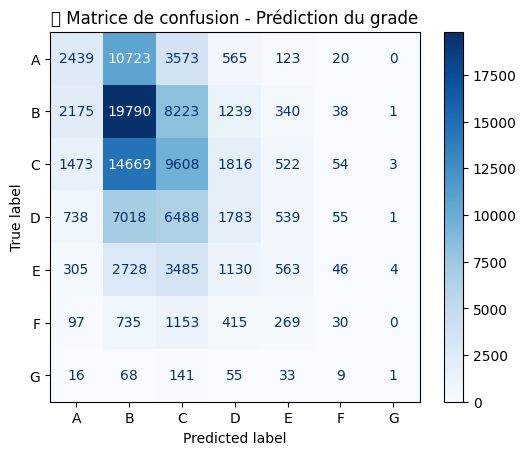

In [6]:
# 📉 Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_grade.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("📊 Matrice de confusion - Prédiction du grade")
plt.show()


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# 🎯 Grille de paramètres à tester
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 🔍 GridSearchCV
print("🔍 Démarrage du GridSearchCV...")
start_time = time.time()
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# ⚙️ Entraînement
grid_search.fit(X_train, y_train)
end_time = time.time()

# ✅ Meilleurs paramètres
print("\n✅ Meilleurs paramètres :", grid_search.best_params_)
print("⏱️ Temps d'exécution :", round(end_time - start_time, 2), "secondes")

# 🌳 Réentraînement avec le meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 📊 Évaluation
print("\n🎯 Accuracy sur test :", round(accuracy_score(y_test, y_pred), 4))
print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 💾 Optionnel : Sauvegarde du modèle
# joblib.dump(best_model, "../../models/decision_tree_model_grade_optimized.joblib")


🔍 Démarrage du GridSearchCV...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

✅ Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
⏱️ Temps d'exécution : 14.91 secondes

🎯 Accuracy sur test : 0.2327

🧾 Rapport de classification :
              precision    recall  f1-score   support

           0       0.25      0.31      0.28     17443
           1       0.35      0.26      0.30     31806
           2       0.29      0.20      0.24     28145
           3       0.20      0.16      0.18     16622
           4       0.13      0.22      0.16      8261
           5       0.05      0.18      0.08      2699
           6       0.01      0.10      0.02       323

    accuracy                           0.23    105299
   macro avg       0.18      0.21      0.18    105299
weighted avg       0.27      0.23      0.24    105299



✅ Jeu d'entraînement : (256349, 8)
✅ Jeu de test : (109865, 8)

🎯 Accuracy du modèle : 0.9221

🧾 Rapport de classification :
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     18239
           2       0.95      0.95      0.95     33065
           3       0.91      0.91      0.91     29598
           4       0.86      0.86      0.86     17256
           5       0.86      0.85      0.85      8526
           6       0.92      0.91      0.92      2855
           7       0.91      0.92      0.92       326

    accuracy                           0.92    109865
   macro avg       0.91      0.91      0.91    109865
weighted avg       0.92      0.92      0.92    109865



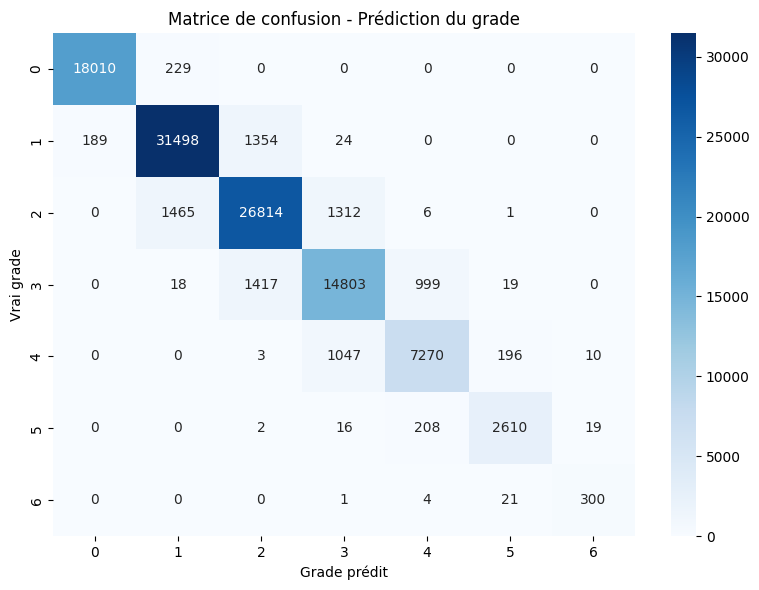

✅ Modèle sauvegardé : ../../models\decision_tree_model.joblib


In [11]:
# 🔹 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# 🔹 Encodage rapide (si pas déjà fait)
grade_order = sorted(df['grade'].dropna().unique())
grade_mapping = {grade: idx + 1 for idx, grade in enumerate(grade_order)}
df['grade_encoded'] = df['grade'].map(grade_mapping)

# Encodage supplémentaire
df['home_ownership_encoded'] = df['home_ownership'].astype('category').cat.codes
df['verification_status_encoded'] = df['verification_status'].astype('category').cat.codes
df['loan_status_encoded'] = (df['loan_status'] == 'Charged Off').astype(int)
df['purpose_encoded'] = df['purpose'].astype('category').cat.codes
df['initial_list_status_encoded'] = df['initial_list_status'].map({'w': 1, 'f': 0})
df['application_type_encoded'] = df['application_type'].astype('category').cat.codes

# 🔹 Sélection des variables explicatives
features = ['loan_amnt', 'emp_length', 'annual_inc',
    'home_ownership_encoded', 'purpose_encoded',
    'int_rate', 'installment', 'term'
]

X = df[features]
y = df['grade_encoded']

# 🔹 Découpage Train / Test (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"✅ Jeu d'entraînement : {X_train.shape}")
print(f"✅ Jeu de test : {X_test.shape}")

# 🔹 Modèle Arbre de Décision
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 🔹 Prédictions
y_pred = model.predict(X_test)

# 🔹 Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy du modèle : {accuracy:.4f}")

print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 🔹 Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Prédiction du grade")
plt.xlabel("Grade prédit")
plt.ylabel("Vrai grade")
plt.tight_layout()
plt.show()

# 🔹 Créer le dossier s'il n'existe pas
model_dir = "../../models"
os.makedirs(model_dir, exist_ok=True)

# 🔹 Sauvegarde du modèle entraîné
model_path = os.path.join(model_dir, "decision_tree_model.joblib")
joblib.dump(model, model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

In [1]:
import numpy as np
import pandas as pd
from joblib import load

# === 1. CHARGER LES MODÈLES ===
clf_model = load("../../models/decision_tree_model.joblib")  # modèle qui prédit A/B/C...
# Tu peux aussi charger le modèle de régression si besoin pour vérifier les prédictions

# === 2. INPUT DE BASE ===
base_features = {
    'loan_amnt': 16800,
    'emp_length': 1,
    'annual_inc': 21000,
    'home_ownership_encoded': 5,
    'purpose_encoded': 2
}

# === 3. GÉNÉRER LES SCÉNARIOS COMBINÉS ===
rate_range = np.linspace(0.05, 0.30, 20)  # Taux de 5% à 30%
terms = [36, 60]  # Durées (en mois)

def generate_cases(base_features):
    cases = []
    for rate in rate_range:
        for term in terms:
            r_month = rate / 12
            installment = base_features['loan_amnt'] * r_month / (1 - (1 + r_month)**-term)
            # Filtre simple : mensualité raisonnable
            if installment < (base_features['annual_inc'] / 12) * 0.4:
                case = base_features.copy()
                case['int_rate'] = rate * 100
                case['installment'] = installment
                case['term'] = term
                cases.append(case)
    return pd.DataFrame(cases)

df_cases = generate_cases(base_features)

# === 4. PASSAGE DANS LE MODÈLE DE CLASSIFICATION ===
features_to_use = ['loan_amnt', 'emp_length', 'annual_inc',
                   'home_ownership_encoded', 'purpose_encoded',
                   'int_rate', 'installment', 'term']

X = df_cases[features_to_use]
df_cases['predicted_grade'] = clf_model.predict(X)

# Si tu veux : récupérer aussi les probabilités de chaque grade
probas = clf_model.predict_proba(X)
df_probas = pd.DataFrame(probas, columns=[f"proba_{c}" for c in clf_model.classes_])
df_cases = pd.concat([df_cases, df_probas], axis=1)

# === 5. TRI DES MEILLEURES PROPOSITIONS ===
# Critère 1 : meilleure probabilité sur le grade le plus haut (ex. A ou B)
# Critère 2 : taux le plus bas compatible avec un bon grade
best = df_cases.sort_values(by=["predicted_grade", "int_rate", "installment"]).head(25)

# === 6. AFFICHAGE ===
print("🔍 Meilleures propositions simulées :")
best[['int_rate', 'installment', 'term', 'predicted_grade'] + [f"proba_{c}" for c in clf_model.classes_]]

🔍 Meilleures propositions simulées :


,int_rate,installment,term,predicted_grade,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7
1,5.000000,317.036725,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,5.000000,503.511071,36,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.315789,327.263664,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.315789,513.495821,36,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7.631579,337.688958,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.631579,523.600288,36,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8.947368,348.311389,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8.947368,533.824081,36,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10.263158,359.129578,60,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,10.263158,544.166774,36,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Filtrer les lignes où le grade est "F" ou "G"
df_fg = df[df['grade'].isin(['G'])]

# Afficher un aperçu des données filtrées
df_fg

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,monthly_income,monthly_payment_calculated,has_outlier,grade_encoded,home_ownership_encoded,verification_status_encoded,loan_status_encoded,purpose_encoded,initial_list_status_encoded,application_type_encoded
80,30000.0,60.0,2.47,8752.8,G,G1,Medtronic,5.0,MORTGAGE,187321.0,...,15610.083333,532.024103,False,7,1,2,0,2,0,1
1429,19800.0,60.0,2.58,5904.8,G,G1,bookkeeper,3.0,RENT,44000.0,...,3666.666667,352.096633,False,7,5,1,1,5,1,1
1967,10000.0,60.0,2.58,2982.3,G,G1,Grocery Manager,10.0,RENT,53816.0,...,4484.666667,177.826582,False,7,5,2,0,2,0,1
2481,15000.0,60.0,22.11,4152.3,G,G1,Kaiser Permanente,10.0,MORTGAGE,108000.0,...,9000.000000,415.222362,False,7,1,2,1,2,0,1
3010,18450.0,60.0,2.58,5502.2,G,G1,Supervision,10.0,MORTGAGE,55000.0,...,4583.333333,328.090044,False,7,1,1,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364728,16000.0,60.0,2.47,4668.2,G,G1,Aetna,1.0,RENT,128000.0,...,10666.666667,283.746188,False,7,5,2,0,8,1,1
364816,20000.0,60.0,2.09,5399.5,G,G3,CITY AND COUNTY OF DENVER,5.0,MORTGAGE,69000.0,...,5750.000000,351.343215,False,7,1,2,1,2,0,1
365158,24000.0,36.0,20.03,892.3,G,G2,Wells Fargo Home Mortgage,6.0,RENT,115872.0,...,9656.000000,892.292902,False,7,5,2,1,2,0,1
365193,25000.0,60.0,2.58,7455.6,G,G1,University of Michigan Health System,10.0,RENT,70000.0,...,5833.333333,444.566456,False,7,5,2,1,2,0,1
